In [29]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
class SincDataset(Dataset):
    def __init__(self, filename):
        xy = np.loadtxt(filename, delimiter=',', dtype=np.float32, skiprows=1)
        self.n_samples = xy.shape[0]

        # here the first column is the class label, the rest are the features
        self.x_data = torch.from_numpy(xy[:, :-1]) # size [n_samples, n_features]
        self.y_data = torch.from_numpy(xy[:, [-1]]) # size [n_samples, 1]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [3]:
# create dataset
dataset = SincDataset('./sinc_data.txt')

# get first sample and unpack
first_data = dataset[0]
features, labels = first_data
print(features, labels)

tensor([ 4.0361e-04, -3.5569e-03, -7.1837e-03, -1.0119e-02, -1.2072e-02,
        -1.2846e-02, -1.2361e-02, -1.0659e-02, -7.9026e-03, -4.3582e-03,
        -3.7104e-04,  3.6690e-03,  7.3649e-03,  1.0352e-02,  1.2334e-02,
         1.3112e-02,  1.2605e-02,  1.0857e-02,  8.0338e-03,  4.4097e-03,
         3.3711e-04, -3.7857e-03, -7.5536e-03, -1.0595e-02, -1.2608e-02,
        -1.3390e-02, -1.2859e-02, -1.1062e-02, -8.1705e-03, -4.4634e-03,
        -3.0173e-04,  3.9073e-03,  7.7503e-03,  1.0848e-02,  1.2893e-02,
         1.3679e-02,  1.3124e-02,  1.1277e-02,  8.3130e-03,  4.5193e-03,
         2.6481e-04, -4.0343e-03, -7.9555e-03, -1.1112e-02, -1.3190e-02,
        -1.3981e-02, -1.3401e-02, -1.1501e-02, -8.4618e-03, -4.5776e-03,
        -2.2624e-04,  4.1668e-03,  8.1699e-03,  1.1388e-02,  1.3501e-02,
         1.4296e-02,  1.3689e-02,  1.1734e-02,  8.6172e-03,  4.6386e-03,
         1.8592e-04, -4.3053e-03, -8.3939e-03, -1.1676e-02, -1.3825e-02,
        -1.4625e-02, -1.3991e-02, -1.1979e-02, -8.7

In [7]:
features.shape

torch.Size([4, 1000])

In [4]:
# Load whole dataset with DataLoader
# shuffle: shuffle data, good for training
# num_workers: faster loading with multiple subprocesses
# !!! IF YOU GET AN ERROR DURING LOADING, SET num_workers TO 0 !!!
train_loader = DataLoader(dataset=dataset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=0)

# convert to an iterator and look at one random sample
dataiter = iter(train_loader)

data = next(dataiter)
features, labels = data
print(features, labels)

tensor([[-0.0058, -0.0081, -0.0097,  ..., -0.0002,  0.0032,  0.0061],
        [-0.0054, -0.0081, -0.0099,  ..., -0.0009,  0.0026,  0.0058],
        [-0.0061, -0.0080, -0.0091,  ...,  0.0011,  0.0040,  0.0065],
        [-0.0021, -0.0022, -0.0020,  ...,  0.0017,  0.0020,  0.0022]]) tensor([[1.6162],
        [1.6566],
        [1.5354],
        [1.1111]])


# Autoencoder

In [6]:
import os
from torch import optim, nn, utils, Tensor
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import lightning as L

In [50]:
# define any number of nn.Modules (or use your current ones)
encoder = nn.Sequential(
    nn.Linear(1000, 500), 
    nn.ReLU(), 
    nn.Linear(500, 250), 
    nn.ReLU(),
    nn.Linear(250, 100), 
    nn.ReLU(),
    nn.Linear(100, 10), 
    )
decoder = nn.Sequential(
    nn.Linear(10, 100), 
    nn.ReLU(),
    nn.Linear(100, 250), 
    nn.ReLU(),
    nn.Linear(250, 500), 
    nn.ReLU(),
    nn.Linear(500, 1000), 
    nn.Tanh(),
    )


# define the LightningModule
class LitAutoEncoder(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


# init the autoencoder
autoencoder = LitAutoEncoder(encoder, decoder)

In [51]:
train_loader = DataLoader(dataset=SincDataset('./sinc_data.txt'),
                          batch_size=4,
                          shuffle=True,
                          num_workers=0)

In [52]:
# train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
trainer = L.Trainer(limit_train_batches=100, max_epochs=20)
trainer.fit(model=autoencoder, train_dataloaders=train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 651 K 
1 | decoder | Sequential | 652 K 
---------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.219     Total estimated model params size (MB)
/home/abhis/miniforge3/envs/lightning-env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/abhis/miniforge3/envs/lightning-env/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [55]:
# load checkpoint
checkpoint = "./lightning_logs/version_2/checkpoints/epoch=19-step=500.ckpt"
autoencoder = LitAutoEncoder.load_from_checkpoint(checkpoint, encoder=encoder, decoder=decoder)

# choose your trained nn.Module
encoder = autoencoder.encoder
encoder.eval()


Sequential(
  (0): Linear(in_features=1000, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=250, bias=True)
  (3): ReLU()
  (4): Linear(in_features=250, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=10, bias=True)
)

Loss = 3.32e-04


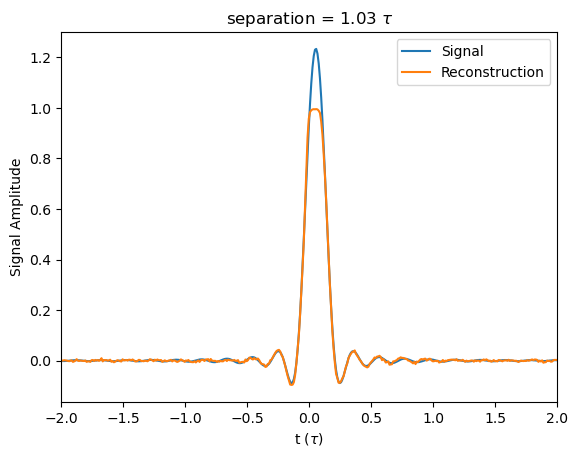

In [81]:

# embed 4 fake images!
fake_x, fake_y = dataset[50]
embeddings = encoder(fake_x)
recon = decoder(embeddings)
tlist = np.linspace(-5,5,  1000)
fig, ax = plt.subplots()
ax.plot(tlist, fake_x.detach().numpy(), label='Signal')
ax.plot(tlist, recon.detach().numpy(), label='Reconstruction')
ax.legend()
ax.set(xlim=(-2,2), xlabel=r't ($\tau$)', ylabel='Signal Amplitude', title=fr'separation = {fake_y.detach().numpy()[0]:.2f} $\tau$')
print(f"Loss = {nn.functional.mse_loss(recon, fake_x):.2e}")


In [ ]:
embeddings = encoder(fake_image_x)
print("⚡" * 20, "\nPredictions (4 image embeddings):\n", embeddings, "\n", "⚡" * 20)

In [18]:
dataset[10]

(tensor([ 4.0740e-03,  4.0404e-04, -3.3204e-03, -6.7334e-03, -9.4984e-03,
         -1.1341e-02, -1.2077e-02, -1.1628e-02, -1.0035e-02, -7.4493e-03,
         -4.1208e-03, -3.7373e-04,  3.4254e-03,  6.9035e-03,  9.7174e-03,
          1.1588e-02,  1.2327e-02,  1.1858e-02,  1.0221e-02,  7.5730e-03,
          4.1696e-03,  3.4213e-04, -3.5349e-03, -7.0807e-03, -9.9455e-03,
         -1.1845e-02, -1.2588e-02, -1.2097e-02, -1.0415e-02, -7.7018e-03,
         -4.2203e-03, -3.0918e-04,  3.6490e-03,  7.2655e-03,  1.0183e-02,
          1.2113e-02,  1.2860e-02,  1.2346e-02,  1.0617e-02,  7.8360e-03,
          4.2732e-03,  2.7479e-04, -3.7681e-03, -7.4582e-03, -1.0431e-02,
         -1.2392e-02, -1.3144e-02, -1.2606e-02, -1.0827e-02, -7.9762e-03,
         -4.3284e-03, -2.3885e-04,  3.8924e-03,  7.6595e-03,  1.0690e-02,
          1.2684e-02,  1.3440e-02,  1.2878e-02,  1.1047e-02,  8.1226e-03,
          4.3860e-03,  2.0126e-04, -4.0224e-03, -7.8699e-03, -1.0961e-02,
         -1.2989e-02, -1.3750e-02, -1.

In [20]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

ModuleNotFoundError: No module named 'tensorboard'